In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [29]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True)


#idx = train_dataset.targets == 1

#train_dataset.data = train_dataset.data[idx]
#train_dataset.targets = train_dataset.targets[idx]


def custom_collate_fn(batch):
    x, y_hat = zip(*batch)
    return (x, y_hat)

dataloader = DataLoader(train_dataset, batch_size=16, collate_fn=custom_collate_fn)

In [30]:
T=256
beta_start=1e-4
beta_end=2e-2
betas=torch.linspace(beta_start, beta_end, steps=T).cuda()
alphas_cumprods = torch.cumprod(1 - betas, dim=0).cuda()
alphas = 1 - betas

In [31]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):

        device = time.device
        half_dim = self.dim // 2

        # Compute the geometric progression of frequencies
        # Formula: 10000^(-2i/d)
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)

        # Calculate arguments for sin and cos: time * frequencies
        # shape: (batch_size, 1) * (1, half_dim) -> (batch_size, half_dim)
        embeddings = time[:, None].float() * embeddings[None, :]

        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings


In [32]:
class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser, self).__init__()

        self.conv1 = nn.Conv2d(1, 128, 3, padding=1) # 28x28x1 -> 26x26x3
        self.conv2 = nn.Conv2d(128,128, 3, padding=1) # 28x28x1 -> 26x26x3
        self.conv3 = nn.Conv2d(128, 1, 3, padding=1) # 28x28x1 -> 26x26x3

        self.conv4 = nn.Conv2d(1, 128, 3, padding=1) # 28x28x1 -> 26x26x3
        self.conv5 = nn.Conv2d(128,128, 3, padding=1) # 28x28x1 -> 26x26x3
        self.conv6 = nn.Conv2d(128, 1, 3, padding=1) # 28x28x1 -> 26x26x3

        self.embed = SinusoidalPositionEmbeddings(32)
        self.l_to_conv = torch.nn.Sequential(
            torch.nn.Linear(32, 28 * 28 ),

        )
        self.l2 = torch.nn.Sequential(

                torch.nn.Linear(28 * 28, 28 * 28),
                torch.nn.ReLU(),
                torch.nn.Linear(28 * 28, 28 * 28),
                torch.nn.ReLU(),
                torch.nn.Linear(28 * 28, 28 * 28),

        )

        self.bnorm1 = nn.BatchNorm2d(128)
        self.bnorm2 = nn.BatchNorm2d(128)
        self.bnorm3 = nn.BatchNorm2d(1)


    def forward(self, x: torch.Tensor, t: torch.Tensor):
        if len(x.shape) == 3:
            B, H, W = x.shape
            x = x.unsqueeze(1)
        else:
            B, C, H, W = x.shape

        # timestep embeddings
        embedded = self.l_to_conv(self.embed(t))

        x = x + embedded.view(B, C, H, W)

        x = F.relu(self.conv1(x) ) + embedded.view(B, C, H, W)
        x = self.bnorm1(x)
        x = F.relu(self.conv2(x)) + embedded.view(B, C, H, W)
        x = self.bnorm2(x)
        x = F.relu(self.conv3(x)) + embedded.view(B, C, H, W)
        x = self.bnorm3(x)

        x = self.l2(x.view(B, -1)).view(B, C, H, W)

        x = F.relu(self.conv4(x)) + embedded.view(B, C, H, W)
        x = F.relu(self.conv5(x)) + embedded.view(B, C, H, W)
        x = F.relu(self.conv6(x)) + embedded.view(B, C, H, W)

        return x



In [43]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return h

class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

    def forward(self, x, t):
        h = self.bnorm(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.relu(self.conv2(h))
        return self.transform(h), h

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.transform = nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1)
        self.conv1 = nn.Conv2d(2 * out_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

    def forward(self, x, skip, t):
        x = self.transform(x)

        if x.shape != skip.shape:
            x = F.interpolate(x, size=skip.shape[2:])

        x = torch.cat([x, skip], dim=1)

        h = self.bnorm(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        return self.relu(self.conv2(h))

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(32),
            nn.Linear(32, 32),
            nn.ReLU()
        )

        # Initial
        self.conv0 = nn.Conv2d(1, 32, 3, padding=1)

        # Down Path
        self.down1 = DownBlock(32, 64, 32)
        self.down2 = DownBlock(64, 128, 32)

        # Bottleneck
        self.bot1 = Block(128, 256, 32)

        self.up1 = UpBlock(256, 128, 32)
        self.up2 = UpBlock(128, 64, 32)
        self.up3 = UpBlock(64, 32, 32)

        self.out = nn.Conv2d(32, 1, 3, padding=1)
        self.class_embed = nn.Embedding(11, 32)

    def forward(self, x, t, c):
         t = self.time_mlp(t)
         t = t + self.class_embed(c)

         x0 = self.conv0(x)

         x1, skip1 = self.down1(x0, t)

         x2, skip2 = self.down2(x1, t)

         x3 = self.bot1(x2, t)

         x = self.up1(x3, skip2, t)
         x = self.up2(x, skip1, t)
         x = self.up3(x, x0, t)

         return self.out(x)


In [44]:
# FORWARD DIFFUSION
# WITH EXPLICIT CALCULATION
# return x at t given x at timestep t - 1
def forward_diffusion(x_tminus1, beta_t):
    epsilon = torch.randn_like(x_tminus1)
    mean = x_tminus1 * torch.sqrt(1 - beta_t)
    std = torch.sqrt(beta_t)
    x = mean + std * epsilon
    return x
def forward_diffusion_at_timestep(x_0, alphas_cumprods, t, eps):
    a_bar_t = alphas_cumprods[t].view(-1,1,1,1)

    mean = x_0 * torch.sqrt(a_bar_t)

    std = torch.sqrt((1 - a_bar_t))
    x = mean + std * eps
    return x

In [ ]:
model = SimpleUNet().cuda().train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.)
loss_fn = torch.nn.MSELoss()
SPLIT = 10000
EPOCHS=250
for epoch in range(EPOCHS):
    for i, (x, y_hat) in enumerate(dataloader):
        x_0 = torch.stack(x).cuda()
        eps = torch.randn_like(x_0).cuda()
        c = torch.tensor(y_hat).cuda()

        null_label = torch.full((x_0.shape[0], ), 10).cuda()

        if i % 10 == 0:
            # train on null label
            t = torch.randint(0, 256, (x_0.shape[0], )).long().cuda()

            x_t = forward_diffusion_at_timestep(x_0, alphas_cumprods, t, eps)

            epsilon_pred = model(x_t, t, null_label)


        else:

            # get t, a batch of random numbers from 0 to T
            t = torch.randint(0, 256, (x_0.shape[0], )).long().cuda()

            x_t = forward_diffusion_at_timestep(x_0, alphas_cumprods, t, eps)

            epsilon_pred = model(x_t, t, c)


        loss = loss_fn(eps, epsilon_pred)
        if i % 1000 == 0:
            print(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

tensor(1.0195, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0533, device='cuda:0', grad_fn=<MseLossBackward0>)


In [309]:
# forward diffusion to

In [41]:
from re import L
# inference loop for a single example
x = torch.randn((1, 1, 28,28)).cuda()
for t_idx in reversed(range(256)):
    t = torch.tensor(t_idx).view(1,).cuda()
    if t_idx > 0:
        z = torch.randn_like(x)
    else:
        z = torch.zeros_like(x)

    c = torch.tensor((6),).cuda()
    null_label = torch.tensor((10,)).cuda()

    eps_pred_cond = model(x, t, c)
    eps_pred_uncond = model(x, t, null_label)

    eps_pred = eps_pred_uncond + 3.0 * (eps_pred_cond - eps_pred_uncond)

    x = (1 / torch.sqrt(alphas[t])) * (x - ((1 - alphas[t]) / torch.sqrt(1 - alphas_cumprods[t])) * eps_pred) + torch.sqrt(betas[t]) * z

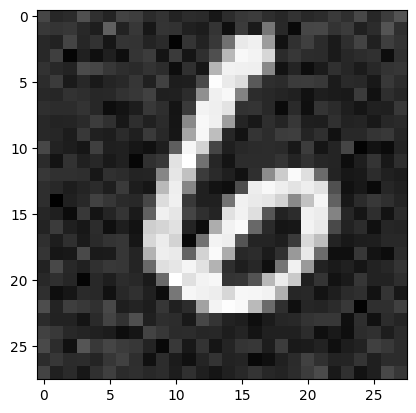

In [42]:
plt.imshow(x.detach().cpu().numpy()[0, 0, :, :], cmap='grey')
